In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import os
from tqdm import tqdm


from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

from shutil import copy

from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import BatchNormalization
from google.colab import drive

# Introduzione
L'obiettivo di questo progetto è quello di addestrare e valutare uno o più modelli di classificazione su un dataset noto, ovvero Extended MNIST letter. Sono state vagliate diverse soluzioni e confrontate tra loro per identificare quale fornisse i risultati migliori. <br />
**N.B.** Il dataset viene caricato da Google Drive quindi qualora si volesse utilizzare il notebook bisogna aggiungere il dataset nel proprio Drive.

In [2]:
#Si collega al drive, dove legge il file csv
drive.mount('/content/gdrive')

dataset_path = '/content/gdrive/MyDrive/Colab/emnist-letters.csv'

# Legge il dataset
df = pd.read_csv(dataset_path)
# Esegue il reshape dei dati, portandoli a img 28x28
X = df.iloc[:,1:].to_numpy().reshape(-1, 28, 28, order="F")
y = df.iloc[:,0].to_numpy()-1
len(X)

Mounted at /content/gdrive


88799

## Definizione di funzioni di utility

In [3]:
# Funzione per stampare le immagini del dataset
def plot_all_letters(X,y):
  # Mappa le etichette con le rispettive lettere
  label_mapping = {i: chr(i + 97) for i in range(26)}  # Mapping per le lettere

  # Ordina le etichette in ordine alfabetico
  sorted_labels = sorted(label_mapping.keys())

  # Crea una griglia di immagini con un'immagine per ogni etichetta
  plt.figure(figsize=(10, 10))
  for i, label in enumerate(sorted_labels):
      # Trova l'indice della prima immagine con l'etichetta corrispondente
      index = np.where(y == label)[0][0]

      plt.subplot(5, 6, i + 1)
      plt.imshow(X[index], cmap='gray')
      plt.title(label_mapping[label])
      plt.axis('off')

  plt.show()

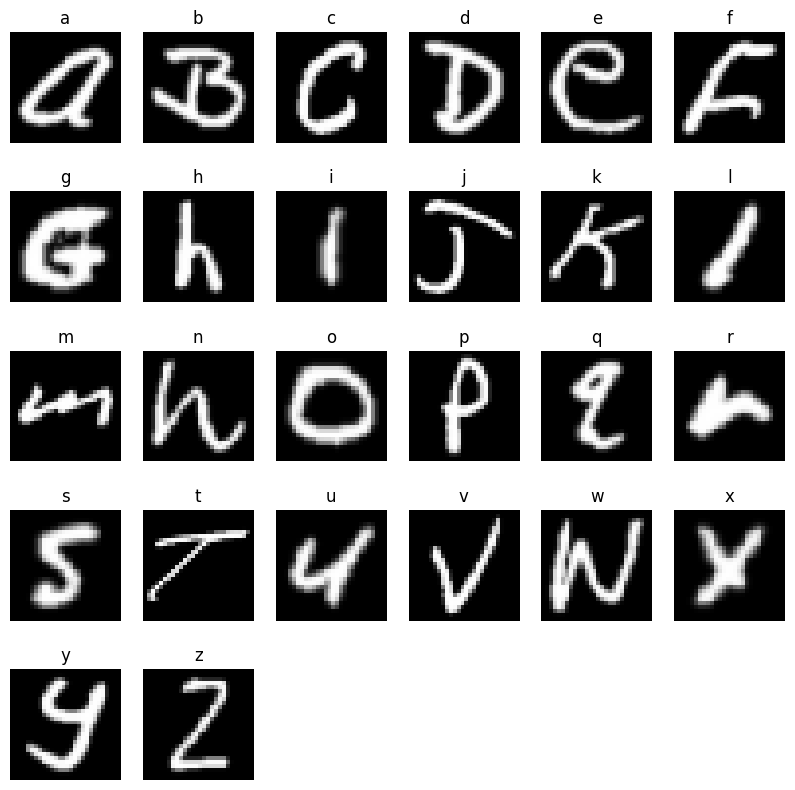

In [4]:
plot_all_letters(X,y)

In [5]:
# Funzione per effettuare una predizione su un'immagine
def predict_image(model, image):
    # Fa la predizione
    predictions = model.predict(np.expand_dims(image, axis=0))

    # Ottiene l'etichetta predetta
    predicted_label = np.argmax(predictions)

    return predicted_label

In [6]:
# Sceglie casualmente un'immagine dal set di test e prova ad etichettargli una label.
def try_prediction(model):
     # Mappa le etichette alle rispettive lettere
    label_mapping = {i: chr(i + 97) for i in range(26)}  # Mapping per le lettere
    index = np.random.randint(0, len(X_test))
    sample_image = X_test[index]

    # Stampa l'immagine
    plt.imshow(sample_image[:, :, 0], cmap='gray')
    plt.title(f"Etichetta reale: {label_mapping[y_test[index]]}")
    plt.show()

    # Fai la predizione sull'immagine utilizzando la funzione predict_image
    predicted_label = predict_image(model, sample_image)
    predicted_letter = label_mapping[predicted_label]

    # Stampa l'etichetta predetta
    print(f"Etichetta predetta: {predicted_letter}")

In [7]:
# Funzione per stampare l'andamento dell'accuracy rispetto le epoche
def plot_training_history(history):
    # Estrai le metriche di addestramento e validazione dalla storia
    train_accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']

    # Visualizza l'andamento dell'accuracy
    epochs = range(1, len(train_accuracy) + 1)
    plt.plot( train_accuracy, label='Training Accuracy')
    plt.plot( val_accuracy, label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

In [8]:
# Funzione per stampare l'andamento della loss rispetto le epoche
def plot_loss_curve(history):
  loss_train_curve = history.history["loss"]
  loss_val_curve = history.history["val_loss"]

  # Visualizza l'andamento della loss
  plt.plot(loss_train_curve, label = "Train")
  plt.plot(loss_val_curve, label = "Validation")
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend(loc = 'upper right')
  plt.title("Loss")
  plt.show()

## Preparazione dei dati

In [9]:
# Divide il dataset in set di addestramento e test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalizza i dati
X_train = X_train / 255.0
X_test = X_test / 255.0

# Aggiunge una dimensione al dataset per il canale di colore
X_train = np.expand_dims(X_train, axis=-1)
X_test = np.expand_dims(X_test, axis=-1)

# Suddivide il set di addestramento in addestramento e validazione
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.15, random_state=42)

print ( "\n Train size: ",len(X_train), "\n Validation size: ", len(X_val),"\n Test size: ", len(X_test))


 Train size:  60383 
 Validation size:  10656 
 Test size:  17760


# KNNeighbors
Si basa sull'idea che le istanze simili si trovano vicine nello spazio delle feature. <br />
Visto la sua semplicità e la sua velocità è stato tenuto in considerazione tra i modelli da utilizzare. <br />
Il tuning degli iperparametri è commentato in quanto rallenta di molto l'esecuzione, il numero di vicini ottimale risulta esser 5.

In [10]:
X_train_knn = X_train.reshape((X_train.shape[0], -1))
X_test_knn = X_test.reshape((X_test.shape[0], -1))

param_dist = {
    'n_neighbors': [3, 5, 7, 9, 11, 13, 15]  # Numero di vicini da considerare
}
  # Cross Validation
  # # Costruisci il classificatore KNN
  # knn_classifier = KNeighborsClassifier()

  # # Definisci il metodo di cross-validation
  # random_search = RandomizedSearchCV(estimator=knn_classifier, param_distributions=param_dist, n_iter=10, cv=5, verbose=2, n_jobs=-1)

  # # Esegui la ricerca casuale dei parametri
  # random_search.fit(X_train_knn, y_train)

  # # Ottieni i migliori parametri trovati
  # best_params = random_search.best_params_
  # print("Best Parameters:", best_params)

  # # Ottieni il modello migliore
  # best_model = random_search.best_estimator_

best_model = KNeighborsClassifier(n_neighbors=5)
best_model.fit(X_train_knn, y_train)
# Valuta il modello migliore sul set di test
test_accuracy = best_model.score(X_test_knn, y_test)
print(f'Accuracy on test set: {test_accuracy:.2f}')


Accuracy on test set: 0.84


#Random Forest
Visto il grande successo di random forest nell'esercizio facoltativo è stato scelto come primo modello da utilizzare. <br />
La *random forest* è un'applicazione specifica del bagging ai decision tree. In una random forest, vengono creati molti decision tree, ognuno addestrato su un sottoinsieme diverso dei dati di addestramento. Inoltre, durante la costruzione di ciascun albero, viene considerato solo un sottoinsieme casuale delle caratteristiche. Questo introduce casualità nella costruzione degli alberi, rendendo ciascun albero diverso.

## RandomizedSearch

Poichè la validazione richiede molto tempo, anche qui è stata eseguita una sola volta, in particolare è stato usato RandomizedSearchCV in quanto più veloce rispetto ad altri tipi di CV. <br />
Una volta individuati i migliori iperparametri sono stati usati per configurare il modello.




In [11]:
# Trasforma le immagini (28 x 28) in vettori di dimensione (1 x 784)
X_train_flatten = X_train.reshape((X_train.shape[0], -1))
X_test_flatten = X_test.reshape((X_test.shape[0], -1))

print ("\n \n \nFIT OUTPUT: ")

# Griglia di iperparametri da testare
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
}


# Di seguito è commentato il codice per eseguire RandomizedSearchCV:
  # # Creazione del classificatore Random Forest
  # random_forest_classifier = RandomForestClassifier(random_state=42)
  # # Creazione di un oggetto RandomizedSearchCV
  # random_search = RandomizedSearchCV(random_forest_classifier, param_grid, n_iter=50, cv=5, scoring='accuracy', random_state=42, verbose=2)
  # # Esecuzione della ricerca casuale
  # random_search.fit(X_train_flatten, y_train)
  # # Ottenimento dei migliori iperparametri
  # best_params = random_search.best_params_
  # print(f'Migliori iperparametri: {best_params}')
  # # Miglior modello configurato con i migliori iperparametri
  # best_model = random_search.best_estimator_

# I migliori iperparametri ottenuti da RandomizedSearchCV
best_params = {
    'n_estimators': 200,
    'max_depth': 20,
    'min_samples_split': 2,
}
# Definisce il numero di core da utilizzare (tutti tranne uno)
n_jobs = -2

# Creazione del classificatore Random Forest con i migliori iperparametri
best_model = RandomForestClassifier(n_jobs=n_jobs, **best_params, random_state=42, verbose=2)

# Addestramento del modello con i migliori iperparametri sull'intero set di addestramento
best_model.fit(X_train_flatten, y_train)

# Valuta il modello sul set di test
test_accuracy = best_model.score(X_test_flatten, y_test)

# Stampa l'accuracy sul set di test
print(f'Accuracy su set di test: {test_accuracy:.4f}')


 
 
FIT OUTPUT: 
building tree 1 of 200
building tree 2 of 200
building tree 3 of 200
building tree 4 of 200
building tree 5 of 200
building tree 6 of 200
building tree 7 of 200
building tree 8 of 200
building tree 9 of 200
building tree 10 of 200
building tree 11 of 200
building tree 12 of 200
building tree 13 of 200
building tree 14 of 200
building tree 15 of 200
building tree 16 of 200
building tree 17 of 200
building tree 18 of 200
building tree 19 of 200
building tree 20 of 200
building tree 21 of 200
building tree 22 of 200
building tree 23 of 200
building tree 24 of 200
building tree 25 of 200
building tree 26 of 200
building tree 27 of 200
building tree 28 of 200
building tree 29 of 200
building tree 30 of 200
building tree 31 of 200
building tree 32 of 200
building tree 33 of 200
building tree 34 of 200
building tree 35 of 200
building tree 36 of 200
building tree 37 of 200
building tree 38 of 200
building tree 39 of 200
building tree 40 of 200


[Parallel(n_jobs=-2)]: Done  40 tasks      | elapsed:   24.4s


building tree 41 of 200
building tree 42 of 200
building tree 43 of 200
building tree 44 of 200
building tree 45 of 200
building tree 46 of 200
building tree 47 of 200
building tree 48 of 200
building tree 49 of 200
building tree 50 of 200
building tree 51 of 200
building tree 52 of 200
building tree 53 of 200
building tree 54 of 200
building tree 55 of 200
building tree 56 of 200
building tree 57 of 200
building tree 58 of 200
building tree 59 of 200
building tree 60 of 200
building tree 61 of 200
building tree 62 of 200
building tree 63 of 200
building tree 64 of 200
building tree 65 of 200
building tree 66 of 200
building tree 67 of 200
building tree 68 of 200
building tree 69 of 200
building tree 70 of 200
building tree 71 of 200
building tree 72 of 200
building tree 73 of 200
building tree 74 of 200
building tree 75 of 200
building tree 76 of 200
building tree 77 of 200
building tree 78 of 200
building tree 79 of 200
building tree 80 of 200
building tree 81 of 200
building tree 82

[Parallel(n_jobs=-2)]: Done 161 tasks      | elapsed:  1.6min


building tree 162 of 200
building tree 163 of 200
building tree 164 of 200
building tree 165 of 200
building tree 166 of 200
building tree 167 of 200
building tree 168 of 200
building tree 169 of 200
building tree 170 of 200
building tree 171 of 200
building tree 172 of 200
building tree 173 of 200
building tree 174 of 200
building tree 175 of 200
building tree 176 of 200
building tree 177 of 200
building tree 178 of 200
building tree 179 of 200
building tree 180 of 200
building tree 181 of 200
building tree 182 of 200
building tree 183 of 200
building tree 184 of 200
building tree 185 of 200
building tree 186 of 200
building tree 187 of 200
building tree 188 of 200
building tree 189 of 200
building tree 190 of 200
building tree 191 of 200
building tree 192 of 200
building tree 193 of 200
building tree 194 of 200
building tree 195 of 200
building tree 196 of 200
building tree 197 of 200
building tree 198 of 200
building tree 199 of 200
building tree 200 of 200


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    1.3s


Accuracy su set di test: 0.8669


#LENET
Un altro modello testato è LeNet. È stata una delle prime rete convoluzionarie proposte. <br />
Il codice è stato preso tra i notebook messi a disposizione nel canale teams del corso. <br />
Raggiunge un livello di accuratezza maggiore rispetto a random forest e KNN.

In [12]:
lenet = tf.keras.models.Sequential([
            tf.keras.layers.Conv2D(filters=6, kernel_size=5, activation='sigmoid', padding='same', input_shape=(28, 28, 1)),
            tf.keras.layers.AvgPool2D(pool_size=2, strides=2),
            tf.keras.layers.Conv2D(filters=16, kernel_size=5,activation='sigmoid'),
            tf.keras.layers.AvgPool2D(pool_size=2, strides=2),
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(120, activation='sigmoid'),
            tf.keras.layers.Dense(84, activation='sigmoid'),
            tf.keras.layers.Dense(26, activation="softmax")]) # Output layer con 26 classi (lettere)


lenet.compile(loss="sparse_categorical_crossentropy",
              optimizer="adam",
              metrics=["accuracy"])

lenet.summary()
batch_size = 256
historyL = lenet.fit(X_train, y_train, epochs=100,
                    validation_split=0.2, batch_size = batch_size,
                   callbacks=[tf.keras.callbacks.EarlyStopping(patience=8)])

# Valuta il modello
test_lossL, test_accL = lenet.evaluate(X_test, y_test)
print(f"\nAccuracy sul set di test: {test_accL}")

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 6)         156       
                                                                 
 average_pooling2d (Average  (None, 14, 14, 6)         0         
 Pooling2D)                                                      
                                                                 
 conv2d_1 (Conv2D)           (None, 10, 10, 16)        2416      
                                                                 
 average_pooling2d_1 (Avera  (None, 5, 5, 16)          0         
 gePooling2D)                                                    
                                                                 
 flatten (Flatten)           (None, 400)               0         
                                                                 
 dense (Dense)               (None, 120)               4

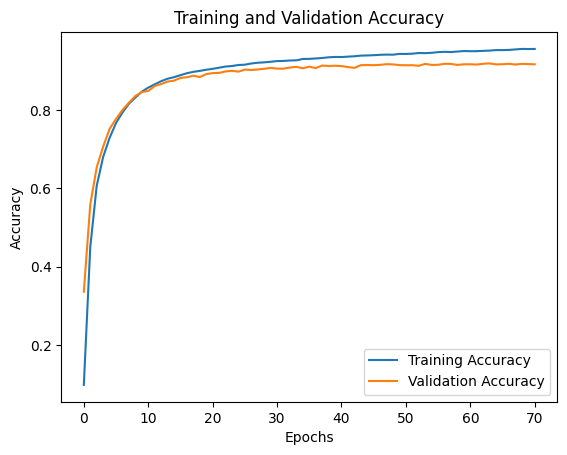

In [13]:
plot_training_history(historyL)

Si evince che LeNet generi una situazione di overfitting, ottenendo un'accuracy maggiore sul training set rispetto a quelle del validation e test set. <br />


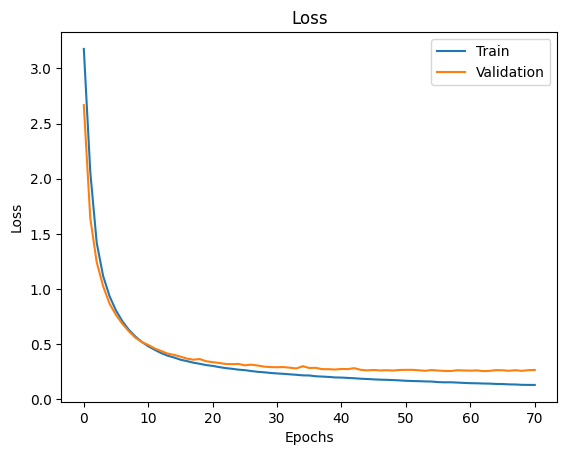

In [14]:
plot_loss_curve(historyL)

# Rete CNN
È la soluzione proposta. <br />
Supera largamente RandomForest e KNN, mentre ottiene un'accuracy di qualche punto percentuale migliore rispetto a LeNet.

È possibile utilizzare anche dataset augmentation settando il rispettivo flag ad 1 (**dataset_aug_flag**). <br />
Si è scelto di applicare la tecnica direttamente sul training set  raddoppiandone la dimensione. <br />
In pratica per ogni elemento del training viene generata un'altra immagine applicandogli delle rotazioni, traslazioni etc. <br />
È possibile anche generare più di una  immagine per ogni istanza, tuttavia il dataset è già notevolmente grande quindi non si ritiene  necessario. <br />
Il motivo per cui la dataset augmentation è effettuata solamente sul training set è per evitare che vengano visti durante l'addestramento degli esempi del test set, il quale idealmente dovrebbe esser un insieme completamente sconosciuto al modello.

In [15]:
dataset_aug_flag = 1

In [16]:
def create_augmented_images(original_images, original_labels, augmentation_factor):
    # Crea un ImageDataGenerator per la generazione di dati
    datagen = ImageDataGenerator(
      rotation_range=10,            # Ruota casualmente le immagini fino a 10 gradi
      width_shift_range=0.1,       # Sposta le immagini da sinistra a destra
      height_shift_range=0.1,      # Sposta le immagini dall'alto al basso
      shear_range=0.10,             # Applica una deformazione trasversale
      zoom_range=0.10,              # Effettua zoom casualmente fino al 10%
      zca_whitening=False,          # Non applicare lo sbiancamento ZCA
      horizontal_flip=False,        # Non effettuare ribaltamenti orizzontali
      vertical_flip=False,          # Non effettuare ribaltamenti verticali
      fill_mode='nearest'           # Riempie i pixel mancanti con i valori più vicini
    )

    # Adatta il generatore alle immagini originali
    datagen.fit(original_images)

    # Inizializza gli array per immagini e etichette generate
    augmented_images = []
    augmented_labels = []

    total_augmented_samples = len(original_images) * augmentation_factor


    # Utilizza flow una sola volta per generare tutte le immagini
    augmented_generator = datagen.flow(original_images, original_labels, batch_size=total_augmented_samples, shuffle=False)

    # Estrai tutte le immagini e le etichette generate
    augmented_images, augmented_labels = next(augmented_generator)

    # Verifica la presenza di valori NaN nelle immagini generate
    if np.isnan(augmented_images).any():
        raise ValueError("Sono presenti valori NaN nelle immagini generate.")

    # Verifica la presenza di valori NaN nelle etichette generate
    if np.isnan(augmented_labels).any():
        raise ValueError("Sono presenti valori NaN nelle etichette generate.")

    print("\n Augmentation complete.\n Augmented dataset length: ", len(augmented_images))

    return augmented_images, augmented_labels

In [17]:
def merge_datasets(original_images, original_labels, augmented_images, augmented_labels):
    merged_images = np.concatenate((original_images, augmented_images))
    merged_labels = np.concatenate((original_labels, augmented_labels))

    return merged_images, merged_labels


 Augmentation complete.
 Augmented dataset length:  60383


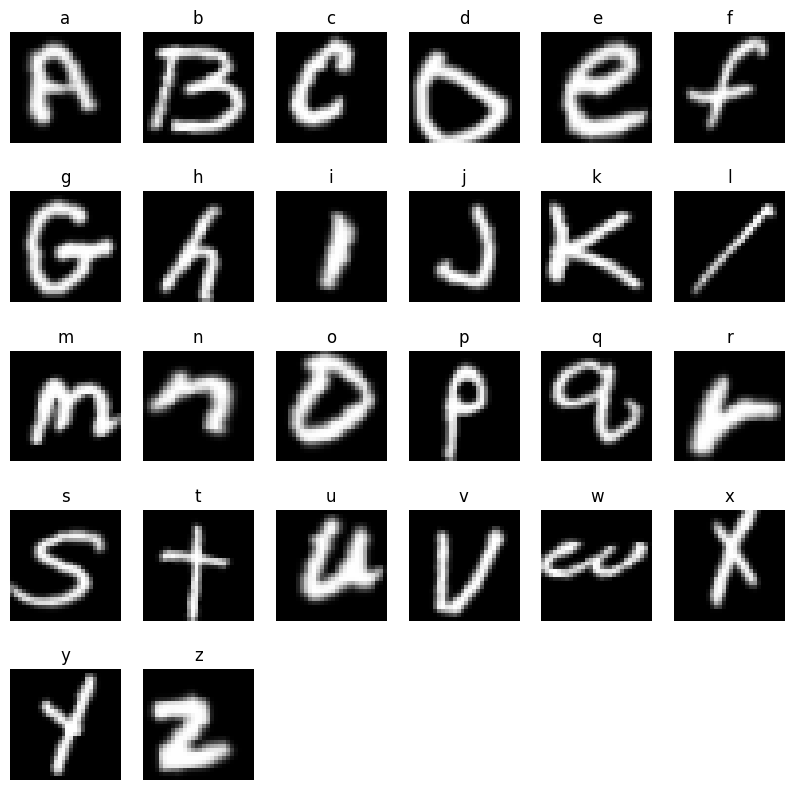

In [18]:
if (dataset_aug_flag == 1):
  X_aug, y_aug  = create_augmented_images(original_images = X_train, original_labels = y_train, augmentation_factor=1)
  plot_all_letters(X_aug, y_aug)

## Modello
Per lavorare con un dataset composto da immagini una soluzione da provare era sicuramente quella di implementare una **rete convoluzionaria**. <br />
La rete prevede due layer convoluzionari seguiti da layer di **MaxPooling**; entrambi hanno uno **stride** della stessa dimensione del pooling. <br />
Successivamente, l'output bidimensionale dei layer convoluzionari viene appiattito con un layer flatten per passarlo in input a due layer completamente connessi. <br />
In tutti i layer è stata utilizzato un regolarizzazione L2 con un fattore di regolarizzazione 0.001. <br />
Sono presenti diverse istanze di **dropout** con probabilità che variano da 0.25 a 0.5. <br />
Nel fit del modello viene utilizzato **early stopping** con un valore di pazienza 8 per evitare di incappare in fenomeni di overfitting sul training set e per ridurre il tempo d'esecuzione.


In [19]:
def convolutional_model(X_train, y_train, dataset_aug_flag):
  if (dataset_aug_flag == 1):
    X_train_augmented, y_train_augmented = merge_datasets(original_images = X_train, original_labels = y_train, augmented_images = X_aug, augmented_labels = y_aug)
    print("Extendend training set: ", len(X_train_augmented))

  # L'architettura della CNN
  model = models.Sequential()
  model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1), kernel_regularizer=tf.keras.regularizers.l2(0.001)))
  model.add(layers.MaxPooling2D((2, 2), strides = 2))
  model.add(layers.Dropout(0.25))  # Aggiunge dropout con p = 1/4

  model.add(layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)))
  model.add(layers.MaxPooling2D((3, 3), strides = 3, padding='same'))

  model.add(layers.Flatten()) #Per trasformare l'uscita bidimensionale dal layer di pooling in un ingresso monodimensionale per il livello denso.

  model.add(layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)))
  model.add(layers.Dropout(0.5))  # Aggiunge dropout con p = 1/2

  model.add(layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)))
  model.add(layers.Dropout(0.25))  # Aggiunge dropout con p = 1/4

  model.add(layers.Dense(26, activation='softmax'))  # Output layer con 26 classi (1 per ogni lettera)

  # Compila il modello
  model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

  if (dataset_aug_flag == 1):
      # Addestra il modello nel caso di DataAugmentation
      batch_size = 512
      history = model.fit(
                        X_train_augmented, y_train_augmented,
                        epochs=100,
                        batch_size=batch_size,
                        validation_data=(X_val, y_val),
                        callbacks=[tf.keras.callbacks.EarlyStopping(patience=8)]) # Early stopping dopo 10 epoche
  else :
    # Addestra il modello senza DataAugmentation
    batch_size = 256
    history = model.fit(X_train, y_train,
                        epochs=100,
                        batch_size=batch_size,
                        validation_data=(X_val, y_val),
                        callbacks=[tf.keras.callbacks.EarlyStopping(patience=8)]) # Early stopping dopo 10 epoche

  model.summary()

  # Valuta il modello
  test_loss, test_acc = model.evaluate(X_test, y_test)
  print(f"\nAccuracy sul set di test: {test_acc}")
  return history, model

## Dataset Augmentation vs Vanilla

### Augmentation

In [20]:
historyAug, modelAug = convolutional_model(X_train = X_train, y_train = y_train, dataset_aug_flag = dataset_aug_flag)

Extendend training set:  120766
Epoch 1/100
236/236 [==============================] - 8s 16ms/step - loss: 1.8439 - accuracy: 0.5627 - val_loss: 0.7784 - val_accuracy: 0.8681
Epoch 2/100
236/236 [==============================] - 3s 13ms/step - loss: 1.0044 - accuracy: 0.7841 - val_loss: 0.6078 - val_accuracy: 0.9027
Epoch 3/100
236/236 [==============================] - 3s 12ms/step - loss: 0.8364 - accuracy: 0.8219 - val_loss: 0.5311 - val_accuracy: 0.9124
Epoch 4/100
236/236 [==============================] - 3s 12ms/step - loss: 0.7429 - accuracy: 0.8393 - val_loss: 0.4867 - val_accuracy: 0.9132
Epoch 5/100
236/236 [==============================] - 3s 13ms/step - loss: 0.6858 - accuracy: 0.8493 - val_loss: 0.4608 - val_accuracy: 0.9185
Epoch 6/100
236/236 [==============================] - 3s 13ms/step - loss: 0.6495 - accuracy: 0.8571 - val_loss: 0.4329 - val_accuracy: 0.9246
Epoch 7/100
236/236 [==============================] - 3s 12ms/step - loss: 0.6254 - accuracy: 0.8620 - 

#### Accuracy and Loss plots

Di seguito sono riportati gli andamenti dell'accuracy e della loss sul training set e sul validation set.

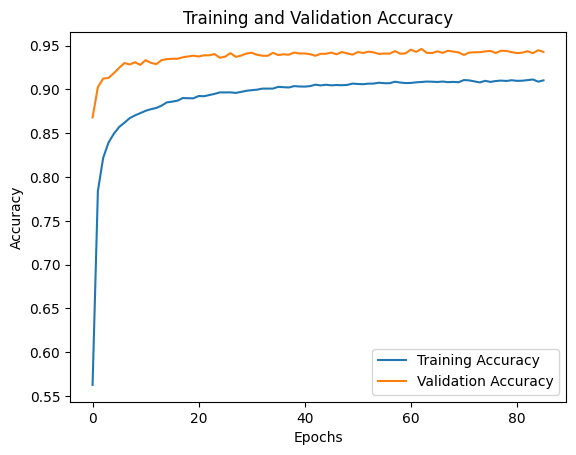

In [21]:
plot_training_history(historyAug)

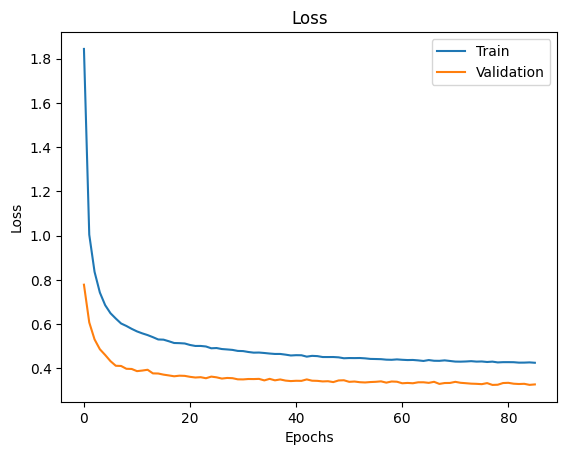

In [22]:
plot_loss_curve(historyAug)

#### Let's try it
Prende in input il modello e prova a classificare un carattere del test set. <br >


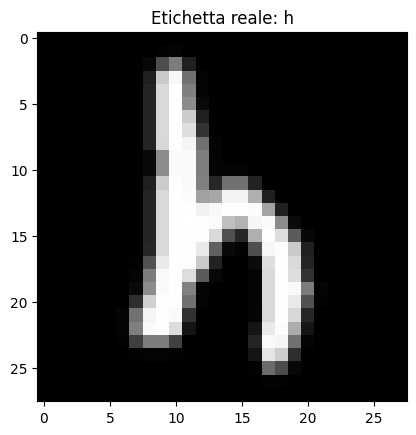

1/1 [==============================] - 0s 251ms/step
Etichetta predetta: h


In [23]:
try_prediction(modelAug)

### Vanilla

In [24]:
history, model = convolutional_model(X_train = X_train, y_train = y_train, dataset_aug_flag = 0)

Epoch 1/100
236/236 [==============================] - 4s 10ms/step - loss: 1.8145 - accuracy: 0.5705 - val_loss: 0.8864 - val_accuracy: 0.8328
Epoch 2/100
236/236 [==============================] - 2s 8ms/step - loss: 0.9788 - accuracy: 0.7970 - val_loss: 0.6851 - val_accuracy: 0.8844
Epoch 3/100
236/236 [==============================] - 2s 8ms/step - loss: 0.8159 - accuracy: 0.8343 - val_loss: 0.6072 - val_accuracy: 0.8949
Epoch 4/100
236/236 [==============================] - 2s 9ms/step - loss: 0.7179 - accuracy: 0.8540 - val_loss: 0.5400 - val_accuracy: 0.9070
Epoch 5/100
236/236 [==============================] - 2s 9ms/step - loss: 0.6611 - accuracy: 0.8625 - val_loss: 0.5140 - val_accuracy: 0.9082
Epoch 6/100
236/236 [==============================] - 2s 8ms/step - loss: 0.6189 - accuracy: 0.8705 - val_loss: 0.4723 - val_accuracy: 0.9159
Epoch 7/100
236/236 [==============================] - 2s 8ms/step - loss: 0.5899 - accuracy: 0.8764 - val_loss: 0.4480 - val_accuracy: 0.921

#### Accuracy and Loss plots

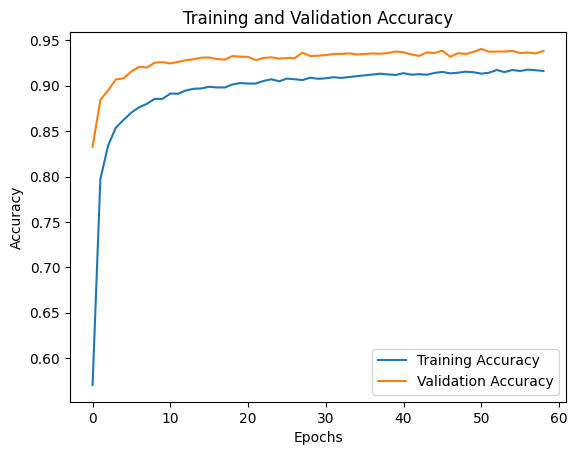

In [25]:
plot_training_history(history)

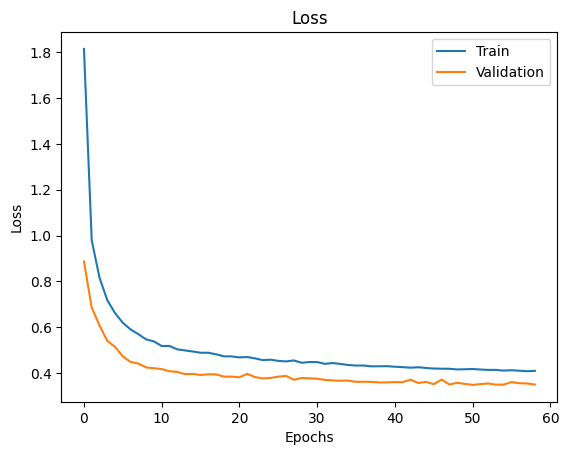

In [26]:
plot_loss_curve(history)

#### Let's try it

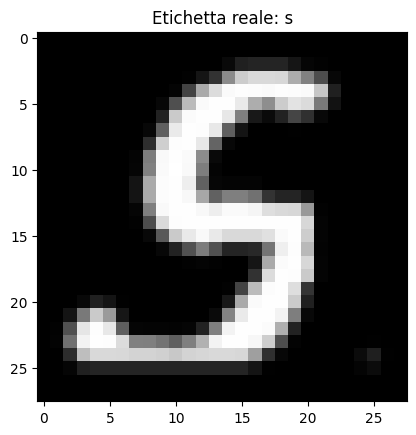

1/1 [==============================] - 0s 71ms/step
Etichetta predetta: s


In [27]:
try_prediction(model)

## Conclusioni
Utilizzando dataset augmentation si migliora di qualche centesimo l'accuracy sul test set. <br />
Al contempo potrebbe rallentare l'addestramento visto la dimensione raddoppiata del training set. <br />
Cercando online si trovano soluzioni decisamente più complesse, su cui sono stati scritti dei paper, che raggiungono accuracy del 96-97%. <br />
Per alcuni split più "fortunati" si raggiunge anche il 94 % di accuracy sul test set. <br />
Per questo il risultato ottenuto risulta esser soddisfacente.